# **Initial Requirements and Importing Dataset**

In [3]:
# # # Importing the important libraries # # #

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [2]:
!wget https://github.com/JINAY08/Image-Segmentation-Using-Random-Walker/raw/main/Assgn4_Data.zip # # # Importing the Dataset

--2022-11-22 11:25:35--  https://github.com/JINAY08/Image-Segmentation-Using-Random-Walker/raw/main/Assgn4_Data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JINAY08/Image-Segmentation-Using-Random-Walker/main/Assgn4_Data.zip [following]
--2022-11-22 11:25:35--  https://raw.githubusercontent.com/JINAY08/Image-Segmentation-Using-Random-Walker/main/Assgn4_Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155060 (151K) [application/zip]
Saving to: ‘Assgn4_Data.zip’

Assgn4_Data.zip     100%[===================>] 151.43K  --.-KB/s    in 0.02s   

2022-11-22 11:25:35 (6.76 MB/s) - ‘Assgn

In [4]:
!unzip -q Assgn4_Data # # # Unzipping the data

In [4]:
from pathlib import Path
imageset = {}
imagesset = []
folder_dir = "a4_data/"
  # print(folder_dir)
images = Path(str(folder_dir)).glob('*.png')  # # # Forms a list of all paths that end with ".png"
  # print(images)
images = sorted(images)
  # print(str(images[1]))
for image in images:
  ind = str(image).split("/")[1].split('.')[0]
  imageset[int(ind)] = cv2.imread(str(image), cv2.IMREAD_GRAYSCALE) # # # Forms a matrix of the paths of all the images
  # print(faces.keys())
    # imagesset.append(str(image))
    # print(imagesset)

Dimensions of each image: (128, 128)


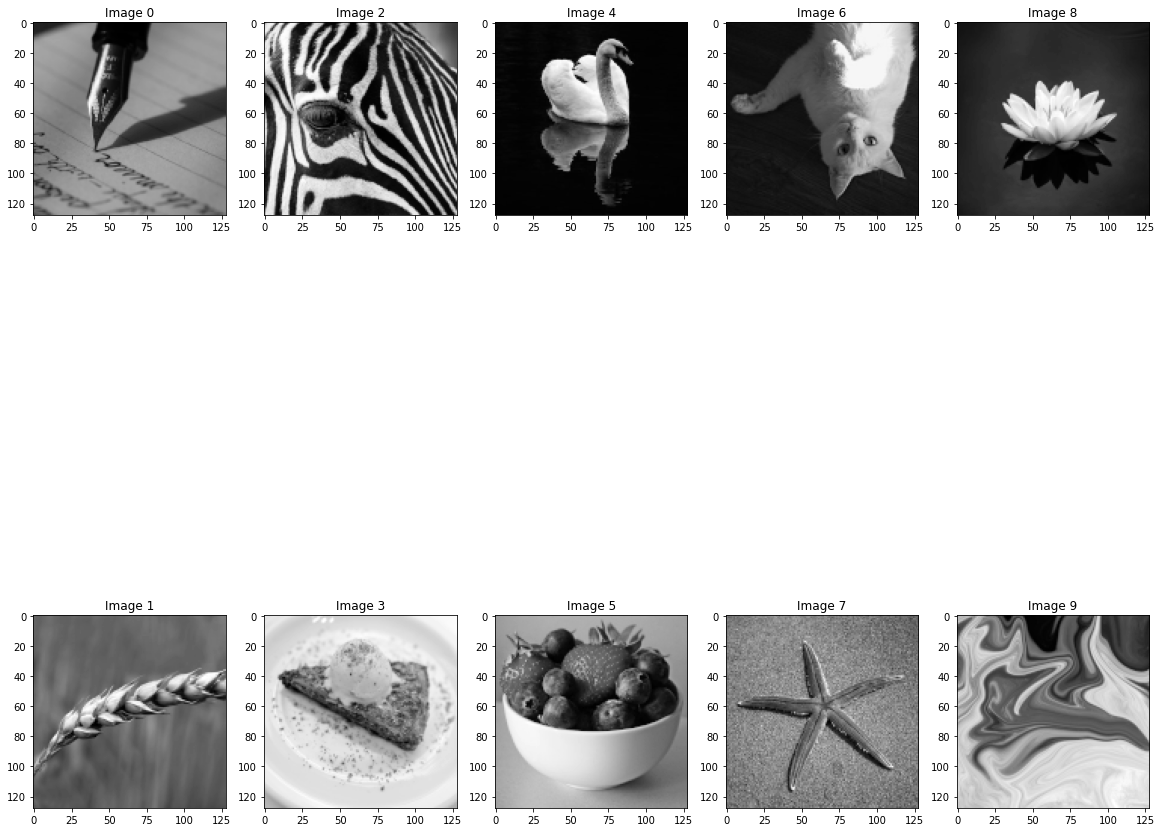

In [5]:
fig, axes = plt.subplots(2,5,figsize=(20,20)) # # # Plotting the images of the dataset
faceimages = list(imageset.values())
height, width = list(imageset.values())[0].shape # # # Height and width of each image

print(f'Dimensions of each image: {height, width}')

for i in range(10):
  axes[i%2][i//2].imshow(faceimages[i], cmap = "gray")
  axes[i%2][i//2].title.set_text(f'Image {i}')
plt.show()

In [6]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import exposure
def initial_denoise(image):
  image = image/255.0 # # # Normalising the images

  # # # Taken from skimage
  sigma_est = np.mean(estimate_sigma(image, multichannel=True))
  patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

  denoised_img = denoise_nl_means(image, h=0.8 * sigma_est,sigma=sigma_est, fast_mode=False, **patch_kw)
  eq_img = exposure.equalize_adapthist(denoised_img)

  return eq_img

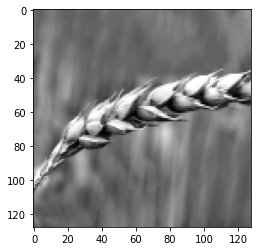

In [7]:
plt.imshow(initial_denoise(imageset[1]), cmap="gray") # # # Plotting an example

In [8]:
def marking(eq_img): # # # Initial Labels(Segments)
  marked = np.zeros((height,width), dtype = np.uint64)
  marked[(eq_img < 0.6) & (eq_img > 0.3)] = 1
  marked[(eq_img > 0.8) & (eq_img < 0.99)] = 2
  return marked

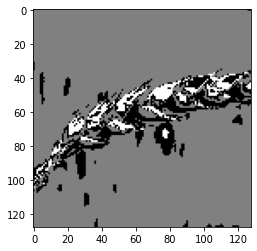

In [9]:
plt.imshow(marking(initial_denoise(imageset[1])), cmap="gray")

# **Defining Random Walker**

In [10]:
defmatrix = []
from math import exp
def weight_function(image, ref, beta): # # The weight function as defined in the paper.
  return exp(-1*((image - ref)**2)*beta)


def random_walker_def(image, segments, beta): # # # Defined Random Walker based on the segmentation.
  # print(image)
  out_image = np.zeros((height,width))
  for y in range(image.shape[1]):
    for x in range(image.shape[0]):
      wt_of_0 = weight_function(image[x][y], 0, beta)
      wt_of_1 = weight_function(image[x][y], 1, beta)


      if((wt_of_0>wt_of_1) & (wt_of_0 > 0.6)): # # Choosing some threshold as required.
        out_image[x][y] = 1

      elif((wt_of_1 > wt_of_0) & (wt_of_1 > 0.6)):
        out_image[x][y]  = 2

    labels = out_image
    seg1 = (labels==1)
    seg2 = (labels==2) # # # Classifying pixels as one of the labels
    all_segments = np.zeros((height, width))
    all_segments[seg1] = 0
    all_segments[seg2] = 1 # # # Finally assigning the pixel values
  # defmatrix.append(all_segments)
  return all_segments



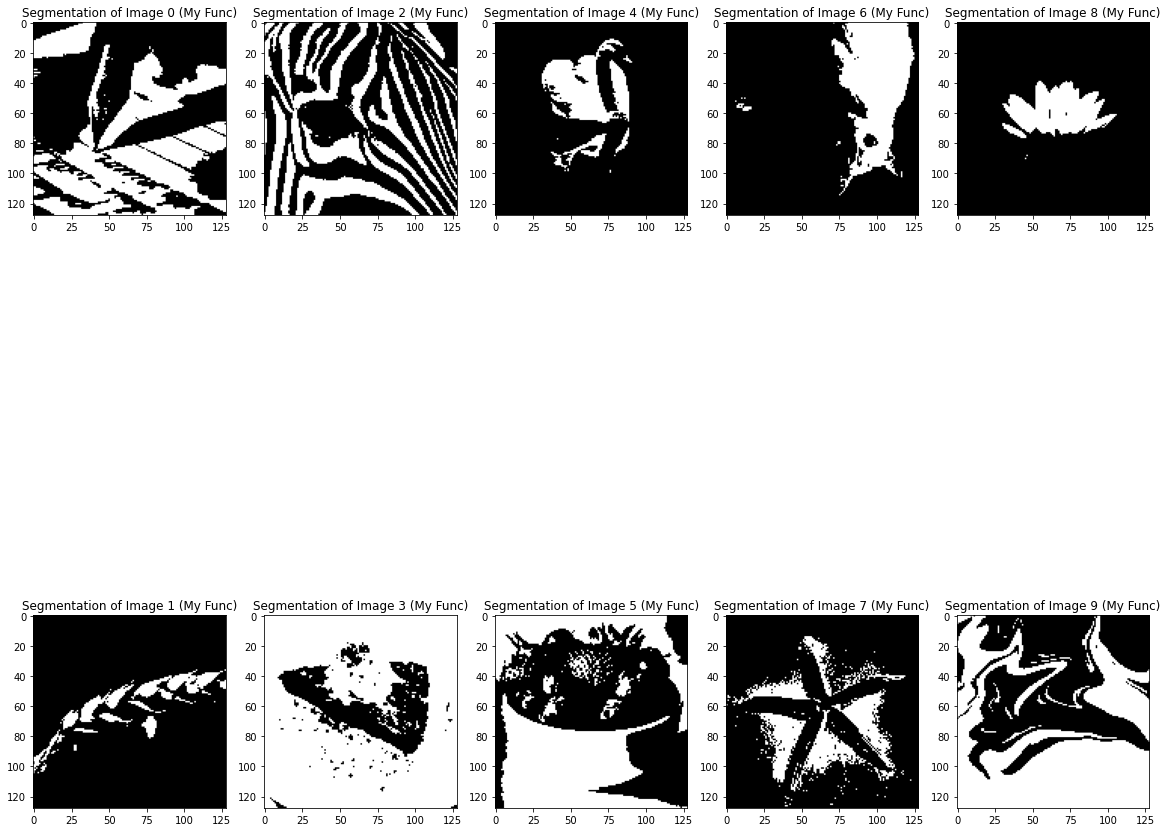

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(20,20))
for i in range(len(imageset.keys())):
  eq_img = initial_denoise(imageset[i])
  marked = marking(eq_img)
  all_segments = random_walker_def(eq_img, marked, beta=5) # # Could change beta for different results
  axes[i%2][i//2].imshow(all_segments, cmap = "gray")
  axes[i%2][i//2].title.set_text(f'Segmentation of Image {i} (My Func)')

# **Comparison with In-Built Random Walker**

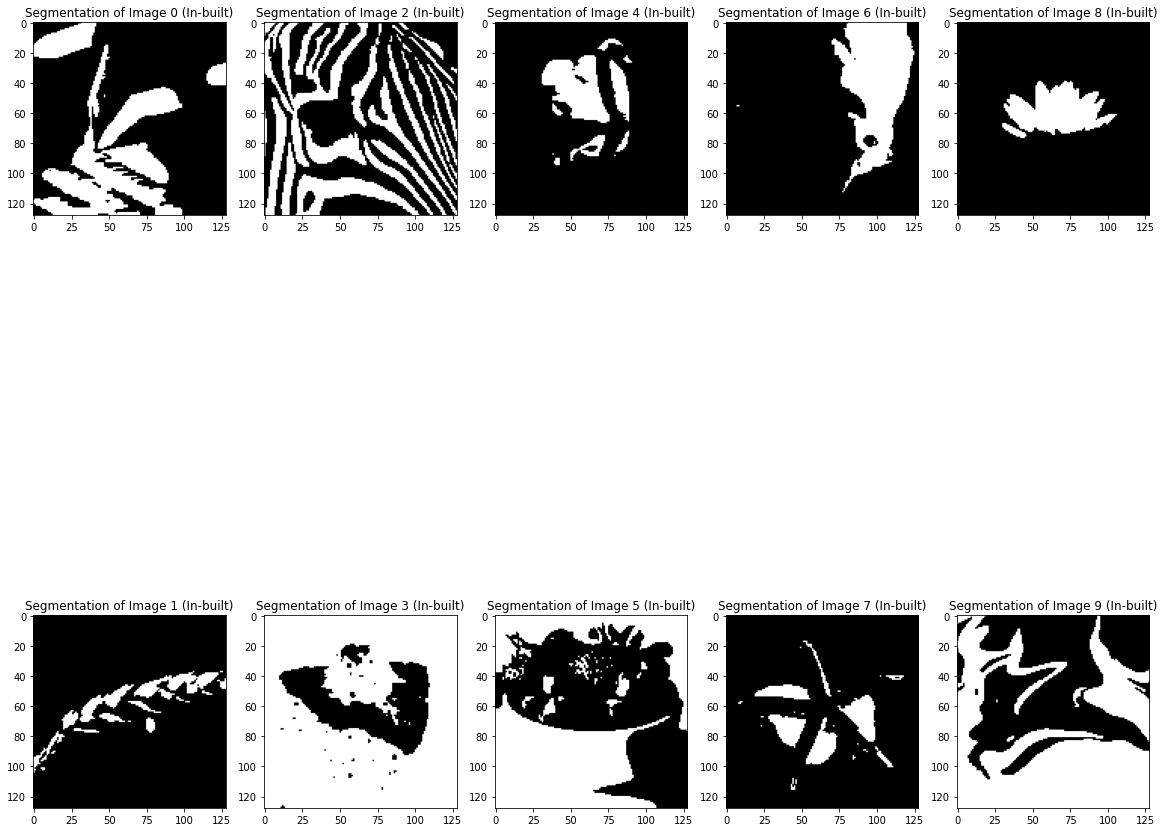

In [19]:
from skimage.segmentation import random_walker # # Using In-Built Random Walker in a similar way.
fig, axes = plt.subplots(2, 5, figsize=(20,20))
inbmatrix = []
for i in range(len(imageset.keys())):
  eq_img = initial_denoise(imageset[i])
  marked = marking(eq_img)
  labels = random_walker(eq_img, marked, beta=200, mode="bf")

  seg1 = (labels==1)
  seg2 = (labels==2)

  all_segments_rw = np.zeros((height, width))
  all_segments_rw[seg1] = 0
  all_segments_rw[seg2] = 1
  # inbmatrix.append(all_segments_rw)
  axes[i%2][i//2].imshow(all_segments_rw, cmap = "gray")
  axes[i%2][i//2].title.set_text(f'Segmentation of Image {i} (In-built)')

# **Comparing the Two Results (Using a Metric Called SSIM or Structural Similarity)**

In [23]:
# # Taken from ourcodeworld

def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [28]:
for i in range(len(imageset.keys())):
  eq_img = initial_denoise(imageset[i])
  marked = marking(eq_img)
  labels = random_walker(eq_img, marked, beta=200, mode="bf")
  seg1 = (labels==1)
  seg2 = (labels==2)
  matrixrw = np.zeros((height, width))
  matrixrw[seg1] = 0
  matrixrw[seg2] = 1

  matrix = random_walker_def(eq_img, marked, beta=5)
  score = calculate_ssim(matrix,matrixrw)
  print(f'SSIM for Image {i} is: {score}')

SSIM for Image 0 is: 0.9827772959471092
SSIM for Image 1 is: 0.9996166985617985
SSIM for Image 2 is: 0.9990171970830073
SSIM for Image 3 is: 0.9989604218060816
SSIM for Image 4 is: 0.9994448086312281
SSIM for Image 5 is: 0.9965880274104739
SSIM for Image 6 is: 0.9994419055962663
SSIM for Image 7 is: 0.9919123718265824
SSIM for Image 8 is: 0.9998706086541438
SSIM for Image 9 is: 0.9985813316734353
